# Bayes Decoding

## Exercise 2

Using the code from the lesson to plot the decoded position as a funcion of time. First the `np.log(poisson.pmf(k,mu))` method is plotted, and then the `poisson.logpmf(k,mu)` method. 

In [2]:
import pickle
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr
import sys
import os

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [3]:
#code: data import
data_file = 'linear_track_data.pickle'
with open(data_file, 'rb') as handle:
    data = pickle.load(handle)

x,t,spikes = data['x'],data['t'],data['spikes']
track_length = data['track_length']
fps = data['fps'] 
n_cells = len(spikes)

In [4]:
# we compute the position at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

In [5]:
spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape

In [6]:
# code decoding
from scipy.stats import poisson

true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
           


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan   


100%|█████████████████████████████████████████████████████████████████████████████| 5026/5026 [00:17<00:00, 290.59it/s]


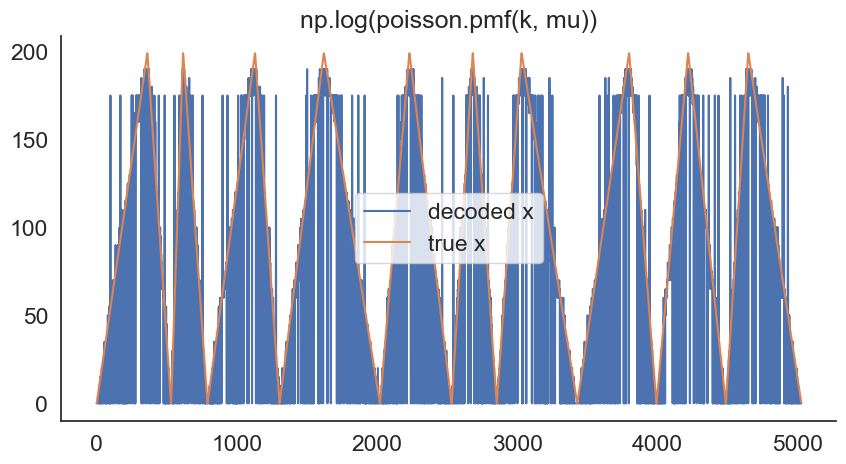

In [7]:
plt.figure(figsize=(10,5))
plt.plot(x_decoded,label= 'decoded x')
plt.plot(true_x,label = 'true x')
plt.title('np.log(poisson.pmf(k, mu))')
plt.legend()

Median error: 6.407201828099659 cm


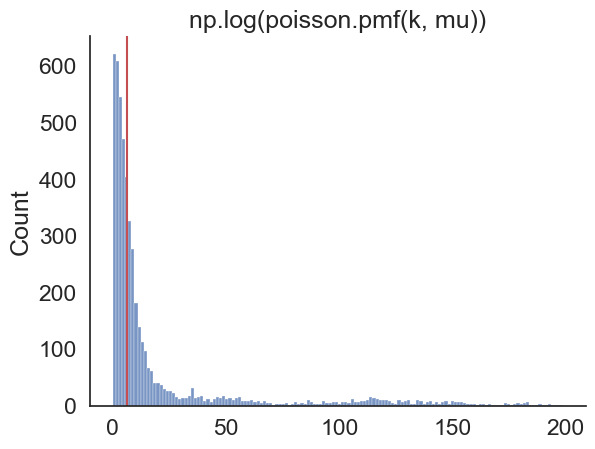

In [8]:
# error distribution
mse = np.sqrt((true_x-x_decoded)**2)
sns.histplot(mse)
plt.axvline(x = np.nanmedian(mse),c='r')
plt.title('np.log(poisson.pmf(k, mu))')
print(f'Median error: {np.nanmedian(mse)} cm')

In [9]:
# code decoding
from scipy.stats import poisson

true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan  

100%|█████████████████████████████████████████████████████████████████████████████| 5026/5026 [00:15<00:00, 323.67it/s]


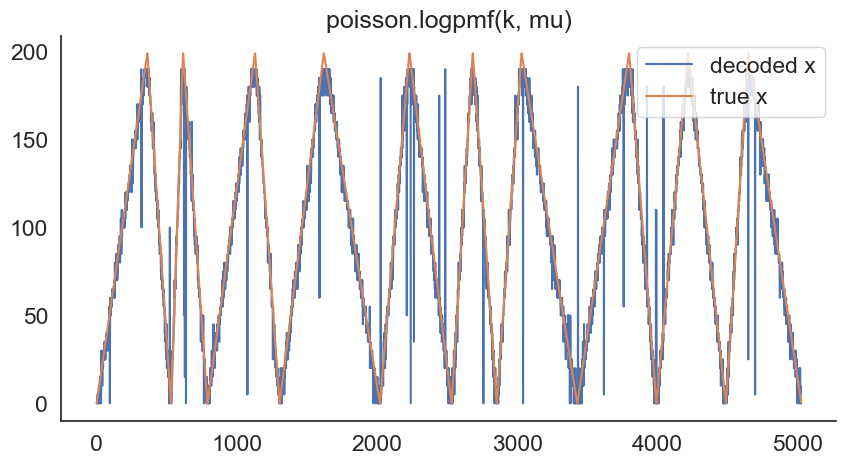

In [10]:
plt.figure(figsize=(10,5))
plt.plot(x_decoded,label= 'decoded x')
plt.plot(true_x,label = 'true x')
plt.title('poisson.logpmf(k, mu)')
plt.legend()

Median error: 3.357155002380459 cm


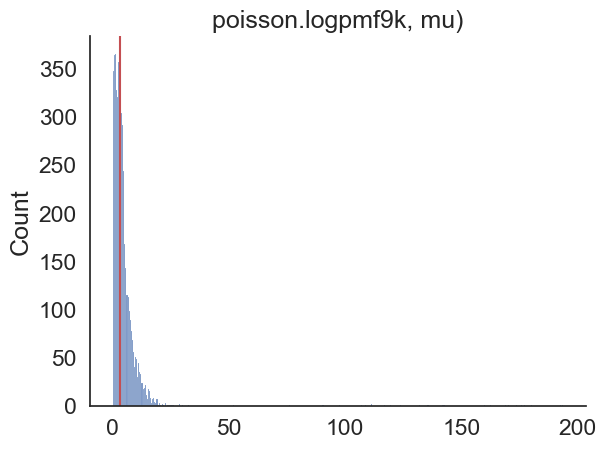

In [11]:
mse = np.sqrt((true_x-x_decoded)**2)
sns.histplot(mse)
plt.axvline(x = np.nanmedian(mse),c='r')
plt.title('poisson.logpmf9k, mu)')
print(f'Median error: {np.nanmedian(mse)} cm')

There is a clear difference in results when using the line:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```
It seems as if the decoding algorithm with the line of code above decodes also the position under the true position curve. The difference in results probably originates from the order the code is executed in. Since for `poisson.logpmf(k,mu)` the log probability is taken, and for `np.log(poisson.pmf(k,mu))` the probability is taken and then the log is calculated. 